## Tree density in/around farmland for Windbreak project 

#### 1.Required data before running the code
- tofi tif by county : https://www.fs.usda.gov/rds/archive/Catalog/
- nlcd tif by county : https://www.mrlc.gov/data?f%5B0%5D=category%3Aland%20cover&f%5B1%5D=region%3Aconus&f%5B2%5D=year%3A2016&f%5B3%5D=year%3A2019
- crop tif by county : https://nassgeodata.gmu.edu/CropScape/

#### 2.	Python code v9 version(windbreak_tree_combined-v9…) is to calculate the sum of trees in/around the crop area by zonal statistics. The final results requires to run several functions as follows.
Function name and process:
-	crop_data(crop raster): 
    - Extract crop values in scope and others to 0
    - Convert raster file to shape file for zonal statistics and 
    - Remove small corn area : less than 2023 m2 = 0.5 acres
    - Apply buffer around crop area: 0.4 mile = 60.96m
    - Save the shape files by county 
-	nlcd_data(nlcd_raster):
    - Resample 30x30 to 1x1
    - Convert Tree values to 1 and others to 0
    - Return the transformed file for merging trees
-	afs_data(afs_raster):
    - Convert Tree values to 1 and others to 0
    - Return the transformed file for merging trees
-	merge_by_gdal(nl_file, af_file, fips):
    - Merge two tree data which has been transformed in previous functions.
    - Save the merged files 
    - note: if there is the merged file for the year, we can run directly zonal_trees without running ‘nlcd_date’, ‘afs_data’ and ‘merge_by_gdal’ functions.
-	zonal_trees(crop_areas, fips):
    - Count trees using the transformed crop shape data and the merged tree data
    - Save tree sum results to dataframe
-	Execution codes using For loop per county:
    - Define the working directory for crop and trees
    - Open the files in the location and run functions defined above per each county
    - Two zonal statistics. One for tree sum of crop areas, another for tree sum of buffer+crop areas to get the tree sum of buffer only area, crop area, and crop+buffer areas
    - Calculate trees and areas, and Save all results to the dataframe and convert to CSV file
    - Remove all opened file and variables before moving to next county for memory efficiency

#### 3. Deliverables
-	Sum of trees, tree density, farmland size in/around farmland by county (csv)
-	TreeSum summary file (csv)
-	Converted and updated Shape File (shp)
-	Transformed and merged trees file (tif)

In [1]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
import rasterstats
from rasterio.enums import Resampling
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.merge import merge
from shapely.geometry import Point
from random import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns

from affine import Affine
from shapely.geometry import shape
from geopandas import GeoSeries, GeoDataFrame
from rasterio.io import MemoryFile


In [2]:
af_dir = '../Data/tofi_ks'
af_file_list = [file for file in os.listdir(af_dir) if file.endswith(".tif")]
print(len(af_file_list))
af_file_list


105


['af_20001_Allen_Co.tif',
 'af_20003_Anderson_Co.tif',
 'af_20005_Atchison_Co.tif',
 'af_20007_Barber_Co.tif',
 'af_20009_Barton_Co.tif',
 'af_20011_Bourbon_Co.tif',
 'af_20013_Brown_Co.tif',
 'af_20015_Butler_Co.tif',
 'af_20017_Chase_Co.tif',
 'af_20019_Chautauqua_Co.tif',
 'af_20021_Cherokee_Co.tif',
 'af_20023_Cheyenne_Co.tif',
 'af_20025_Clark_Co.tif',
 'af_20027_Clay_Co.tif',
 'af_20029_Cloud_Co.tif',
 'af_20031_Coffey_Co.tif',
 'af_20033_Comanche_Co.tif',
 'af_20035_Cowley_Co.tif',
 'af_20037_Crawford_Co.tif',
 'af_20039_Decatur_Co.tif',
 'af_20041_Dickinson_Co.tif',
 'af_20043_Doniphan_Co.tif',
 'af_20045_Douglas_Co.tif',
 'af_20047_Edwards_Co.tif',
 'af_20049_Elk_Co.tif',
 'af_20051_Ellis_Co.tif',
 'af_20053_Ellsworth_Co.tif',
 'af_20055_Finney_Co.tif',
 'af_20057_Ford_Co.tif',
 'af_20059_Franklin_Co.tif',
 'af_20061_Geary_Co.tif',
 'af_20063_Gove_Co.tif',
 'af_20065_Graham_Co.tif',
 'af_20067_Grant_Co.tif',
 'af_20069_Gray_Co.tif',
 'af_20071_Greeley_Co.tif',
 'af_20073_Green

In [3]:
# 1:Corn, 5:Soybeans, 6:Sunflower, 23:Spring Wheat, 24:Winter Wheat, 26:Dbl Crop WinWht/Soybeans
# 225:Dbl Crop WinWht/Corn, 226:Dbl Crop Oats/Corn, 236:Dbl Cropp WinWht/Sorghum, 237:Dbl Crop Barley/Corn, 
# 238:Dbl Crop WinWht/Cotten, 240:Dbl Crop Soybeans/Oats, 241:bl Crop Corn/Soybeans, 254: Dbl Crop Barley/Soybeans, 
# To inlcude: 1, 5, 6, 23, 24, 26, 225,226, 236, 237, 238, 240, 241, 254
# Crop data operation and crop table with crop area, crop_buffer area, buffer_only area 
def crop_data(crop_raster):  
    crop = [1,5,6,23,24, 26, 225, 226, 236, 237, 238, 240, 241, 254] # crops in target
    crop_rvalue = crop_raster.read()
    crop_all= crop_rvalue.astype(np.uint8)
#     crop_corn[crop_corn!=1]=0  # corn only
    for key, value in enumerate(crop_all[0]):
        for k, v in enumerate(value):
            if v not in crop:           # Get only crop values in scope
                crop_all[0][key][k]= 0  # Convert to 0 if the value is not in the crop list.

    # crop raster to vector
    crop_vec = pd.DataFrame(columns=['crop_id','geometry'])
    i=0
    for shp, val in rasterio.features.shapes(crop_all, transform=crop_raster.transform):
    #     print('%s: %s'% (val, shape(shp)))
        crop_vec.loc[i]=[val]+[shape(shp)]
        i+=1
    crop_vec=GeoDataFrame(crop_vec['crop_id'],geometry=crop_vec['geometry'])  
    crop_vec=crop_vec[crop_vec['crop_id']!=0]                                         

    # Remove small corn areas, unit:
    lg = crop_vec.area > 2023  # 2023m2 is  0.5 acres
    selected_crop_vec = crop_vec.loc[lg]
    selected_crop_vec['geometry'] = selected_crop_vec.buffer(0) # for difference(buffer - farm) calculation, adjust the geometry. Otherwise, had errors.
    selected_crop_vec.crs = "epsg:26914"
    # - save shape file of selected_corn_vec
    selected_crop_vec['Area_Farm_m2'] = selected_crop_vec['geometry'].area

    # Appy buffer to calculate the amount of trees around the crops. 
    # 200 feet is 61 meter
    # buffer results includes only buffer polygon. So need to copy the value and add polygon
    selected_crop_vec_buffer = selected_crop_vec.copy()
    selected_crop_vec_buffer['geometry']= selected_crop_vec.buffer(60.96) # 0.4 mile = 60.96m. The measurement of EPSG 26914 is meter.
    selected_crop_vec_buffer.crs = "epsg:26914"
    selected_crop_vec['Area_Farm_and_buffer_m2'] = round(selected_crop_vec_buffer['geometry'].area,1)  # size of farm area and buffer area
    
    # buffer only polygon
    selected_crop_vec_bufferonly = selected_crop_vec_buffer.copy()
    selected_crop_vec_bufferonly['geometry'] = selected_crop_vec_buffer.difference(selected_crop_vec)
    selected_crop_vec['Area_buffer_m2'] = round(selected_crop_vec_bufferonly['geometry'].area,1)
    selected_crop_vec = selected_crop_vec.reset_index() # As the selected_crop_vec results contain index with farmland id without continuous values like 1,4 12, it should be reset_indexed to use concat with tree dataset below.
    selected_crop_vec.rename(columns={'index': 'Farmland_id'}, inplace=True)
    #     df_farm_buffer_tree_combined.rename(columns={'index': 'Farmland_id'}, inplace=True)
    # selected_crop_vec has farmland_id, selected farm area id, area size for farm only, farm_buffer, buffer area
    
    # Save as shape files
    selected_crop_vec.to_file("./Results/Shape_Files/"+crop_year+"/farm_"+file[3:-7]+".shp")
    selected_crop_vec_buffer.to_file("./Results/Shape_Files/"+crop_year+"/farm_buf_"+file[3:-7]+".shp")
    selected_crop_vec_bufferonly.to_file("./Results/Shape_Files/"+crop_year+"/buffer_only_"+file[3:-7]+".shp")
    
    # All Area results is in selected_crop_vec table
    return selected_crop_vec, selected_crop_vec_buffer  # return tables with crop values and geometries.  


In [4]:
## NLCD Tree Raster data
# Resampling 30x30 to 1x1,Tree to 1 and others to 0 

def nlcd_data(nlcd_raster):
    upscale_factor = 30 
    nlcd_tree = nlcd_raster.read(
        out_shape=(
            nlcd_raster.count,
            round(nlcd_raster.height * upscale_factor),  # 30 times more cells than nlcd_raster height
            round(nlcd_raster.width * upscale_factor)    # 30 times more cells than nlcd_raster width
        ),
        resampling=Resampling.nearest # same results with bilinear sampling which is for continous data.
    )

    # scale image transform
    transform = nlcd_raster.transform * nlcd_raster.transform.scale(   # 30 scale * 1/30 = 1
        (nlcd_raster.width / nlcd_tree.shape[-1]),   
        (nlcd_raster.height / nlcd_tree.shape[-2])   
        )

#     print("nlcd raster resampled to 1m :\n", transform)  # transformed nlcd raster from 30m to 1m

    # Extract only Tree values
    nlcd_tree[nlcd_tree==41]=1
    nlcd_tree[nlcd_tree==42]=1
    nlcd_tree[nlcd_tree==43]=1
    nlcd_tree[nlcd_tree==90]=1
    nlcd_tree[nlcd_tree!=1]=0
    
    # save to new raster file
    out_meta = nlcd_raster.meta.copy()

    # Update the metadata
    out_meta.update({"driver": "GTiff",
                     "height": nlcd_tree.shape[1],  # Scaled cells
                     "width": nlcd_tree.shape[2],   # Scaled cells
                     "transform": transform,  # 1m 
                     "crs": nlcd_raster.crs,
                     "compress": "LZW"
                      }
                     )

    with rasterio.open('nl_converted_'+ file[3:8]+'.TIF', "w", **out_meta) as dest:
         dest.write(nlcd_tree)
            
    nlcd_src = rasterio.open('nl_converted_'+ file[3:8]+'.TIF')

    return nlcd_src

In [5]:
## AFS Tree data
# Convert Tree value to 1, others are 0. 

def afs_data(afs_raster):
    afs_tree=afs_raster.read()
    afs_tree[afs_tree!=1]=0

    # save to new raster file with updated raster values
    out_meta = afs_raster.meta.copy()
    
    # Update the metadata
    out_meta.update({"driver": "GTiff",
                    "compress": "LZW"})
                     
    with rasterio.open('af_converted_'+ file[3:8]+'.TIF', "w", **out_meta) as dest: #img, tif
         dest.write(afs_tree)
            
    afs_src = rasterio.open('af_converted_'+ file[3:8]+'.TIF')    
    
    return afs_src


In [6]:
# gdal
from osgeo import gdal

def merge_by_gdal(nl_file, af_file, fips):
    demList = [nl_file, af_file]
    vrt = gdal.BuildVRT("./Results/gdal_merged_"+cnty+".vrt", demList)
    translateoptions = gdal.TranslateOptions(format = 'GTiff', creationOptions = ['COMPRESS=LZW'])
    gdal.Translate("./Results/Merged_Trees/" + nlcd_year + "/gdal_merged_"+ fips+ "_" + nlcd_year + ".tif", vrt, xRes=1, yRes=-1, options=translateoptions)
    vrt = None
    

In [7]:
## zonal statistics, pixcel counts for each polygon
# 1:Corn, 5:Soybeans, 6:Sunflower, 23:Spring Wheat, 24:Winter Wheat, 26:Dbl Crop WinWht/Soybeans
# 225:Dbl Crop WinWht/Corn, 226:Dbl Crop Oats/Corn, 236:Dbl Cropp WinWht/Sorghum, 237:Dbl Crop Barley/Corn, 
# 238:Dbl Crop WinWht/Cotten, 240:Dbl Crop Soybeans/Oats, 241:bl Crop Corn/Soybeans, 254: Dbl Crop Barley/Soybeans, 
# To inlcude: 1, 5, 6, 23, 24, 26, 225,226, 236, 237, 238, 240, 241, 254
def zonal_trees(crop_areas,fips):
    merged_file = "./Results/Merged_Trees/" + nlcd_year + "/gdal_merged_"+ fips+ "_" + nlcd_year + ".tif"
    merged_raster = rasterio.open(merged_file)
    cmap = {1.0: 'Tree', 0.0: 'Others'}

    # Details about zonal_stats : https://pythonhosted.org/rasterstats/manual.html
    zonal_trees = rasterstats.zonal_stats(crop_areas, 
                                merged_file, 
                                affine=merged_raster.transform, geojson_out=True,
                                categorical=True, # Using Categorical, the output is dictionary with the unique raster values as keys and pixel counts as values
                                category_map=cmap, # Display results 1 to Tree, 0 to Others
                                all_touched=True  # Count all raster values touched by polygon boundary    
                                               )

    # Save the required data and display as dataframe
    tree_dic = {"Farmland_id":[], "Trees_area_m2":[]
               }
    
    for row in zonal_trees:
        farm_id = row['id']  # 
        tree_dic['Farmland_id'].append(farm_id)  
        if 'Tree' in row['properties']:
            tree_dic['Trees_area_m2'].append(row['properties']['Tree'])

        else:
            tree_dic['Trees_area_m2'].append(0)

    total_trees = sum(tree_dic['Trees_area_m2'])        
    df_trees = pd.DataFrame.from_dict(tree_dic)
    return total_trees, df_trees  


In [8]:
#************************************
# Runing in the local jupyter notebook
# To get only combined tree tif fies after merging them.
# same tree merged results for (2019,2018),(2017,2016,2015,2014),(2013,2012,2011)
# year = '2016'  # for tofi, use one dataset(year of 2014/2015). for nlcd, use year of 2019, 2016, 2011 dataset
crop_year = '2011'   #2014
nlcd_year = '2011'   # 2016
state = 'ks'
af_dir = '../Data/tofi_'+state+'/'
nl_dir = '../Data/nlcd/nlcd_'+ nlcd_year+'/' 
cc_dir = '../Data/cc/'+ crop_year+'/' 

df_summery_cnty = pd.DataFrame()
for file in af_file_list[0:2]:
    print("FIPS number and county name :",file[3:-7])
    cnty = file[3:8]   # county name
    af_raster = rasterio.open(af_dir + file)   ##### Run one time per each nlcd_year.
    nl_raster = rasterio.open(nl_dir + 'nl_'+ cnty+'_'+ nlcd_year+'.TIF')
    cc_raster = rasterio.open(cc_dir + 'cc_'+ cnty + '_' + crop_year +'.TIF')
   
    selected_crop_vec, selected_crop_vec_buffer = crop_data(cc_raster)
        
    nlcd_src = nlcd_data(nl_raster)
    afs_src = afs_data(af_raster)
    merge_by_gdal('nl_converted_'+cnty+'.TIF', 'af_converted_'+cnty+'.TIF', cnty) # same tree_merged data for some years
    total_trees_farm_buffer_cnty, df_trees_farm_and_buffer = zonal_trees(selected_crop_vec_buffer, cnty)
    total_trees_farm_only_cnty, df_trees_farm_only = zonal_trees(selected_crop_vec, cnty)

#    County level with all farm lands
    df_trees_farm_and_buffer['Farmland_id'] = df_trees_farm_and_buffer['Farmland_id'].astype('int64') # Make same format
    df_trees_farm_only.rename(columns={'Trees_area_m2': 'Trees_farm_m2'}, inplace=True)
    df_trees_farm_and_buffer.rename(columns={'Trees_area_m2': 'Trees_farm_and_buffer_m2'}, inplace=True)
    
    # Code explanation of concat below
    # Results of 'df_trees_farm_and_buffer' and 'df_trees_farm_only' are treesum from zonal_trees function
    # df_farm_buffer_tree_combined is to combine 3 datasets explained above
    # As all datasets have same farmland row and sequenced index, use concat to combine it.(Incase using join, use farmland_id)
    df_farm_buffer_tree_combined = pd.concat([selected_crop_vec,df_trees_farm_and_buffer['Trees_farm_and_buffer_m2'],df_trees_farm_only['Trees_farm_m2']], axis=1)
    df_farm_buffer_tree_combined['Trees_buffer_m2'] = df_trees_farm_and_buffer['Trees_farm_and_buffer_m2'] - df_trees_farm_only['Trees_farm_m2']
    df_farm_buffer_tree_combined['Buffer_tree_ratio'] = round(df_farm_buffer_tree_combined['Trees_buffer_m2']/df_farm_buffer_tree_combined['Trees_farm_and_buffer_m2'],3)
    
    df_farm_buffer_tree_combined.to_csv('./Results/TreeSum/'+ crop_year +'/trees_farms_all_'+file[3:-7]+ '_' + crop_year +'.csv')
    
    # State with all counties: Creating tree sum by crop number by county level
    df_group = df_farm_buffer_tree_combined.groupby('crop_id')[['Area_Farm_m2','Area_Farm_and_buffer_m2','Area_buffer_m2','Trees_farm_and_buffer_m2','Trees_farm_m2','Trees_buffer_m2']].sum().reset_index()
    df_group['County_Code'] = file[3:8]
    df_group['County_Name'] = file[9:-7]
    df_group['cnty_farm_buffer_trees'] = total_trees_farm_buffer_cnty
    df_group['cnty_farm_trees'] = total_trees_farm_only_cnty
    df_group['Buffer_tree_ratio'] = round(df_group['Trees_buffer_m2']/df_group['Trees_farm_and_buffer_m2'],3)
    df_summery_cnty = pd.concat([df_summery_cnty, df_group])
    
    del cc_raster,  df_trees_farm_and_buffer, df_trees_farm_only, df_farm_buffer_tree_combined,af_raster, nl_raster, nlcd_src, afs_src
    os.remove('nl_converted_'+cnty+'.TIF')
    os.remove('af_converted_'+cnty+'.TIF')
    os.remove("./Results/gdal_merged_"+cnty+".vrt")

df_summery_cnty.to_csv('./Results/TreeSum/'+state+'_'+ crop_year + '_summary.csv')


FIPS number and county name : 20001_Allen


C:\Users\maths\anaconda3\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\maths\anaconda3\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\maths\anaconda3\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


FIPS number and county name : 20003_Anderson


C:\Users\maths\anaconda3\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\maths\anaconda3\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\maths\anaconda3\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [11]:
# Results of sum of trees, area size and tree density per farmlad
df = pd.read_csv("./Results/TreeSum/2011/trees_farms_all_20001_Allen_2011.csv")
df.head(10)

,Unnamed: 0,Farmland_id,crop_id,geometry,Area_Farm_m2,Area_Farm_and_buffer_m2,Area_buffer_m2,Trees_farm_and_buffer_m2,Trees_farm_m2,Trees_buffer_m2,Buffer_tree_ratio
0,0,1,26.0,"POLYGON ((841634.8309345037 4217137.46857776, ...",4500.0,37385.4,32885.4,0,0,0,NaN
1,1,2,24.0,"POLYGON ((841814.8309345037 4217137.46857776, ...",3600.0,32827.8,29227.8,2403,0,2403,1.0
2,2,3,24.0,"POLYGON ((841994.8309345037 4217167.46857776, ...",2700.0,28309.6,25609.6,5763,1,5762,1.0
3,3,4,1.0,"POLYGON ((840704.8309345037 4217107.46857776, ...",14400.0,58481.6,44081.6,23,0,23,1.0
4,4,5,26.0,"POLYGON ((841454.8309345037 4217107.46857776, ...",3600.0,32190.5,28590.5,0,0,0,NaN
5,5,7,26.0,"POLYGON ((841514.8309345037 4217107.46857776, ...",2700.0,28986.2,26286.2,0,0,0,NaN
6,6,9,26.0,"POLYGON ((841904.8309345037 4217137.46857776, ...",7200.0,43946.3,36746.3,12295,0,12295,1.0
7,7,18,1.0,"POLYGON ((838574.8309345037 4217017.46857776, ...",2700.0,28986.2,26286.2,0,0,0,NaN
8,8,20,24.0,"POLYGON ((841604.8309345037 4217077.46857776, ...",6300.0,43006.9,36706.9,0,0,0,NaN
9,9,21,26.0,"POLYGON ((841664.8309345037 4217017.46857776, ...",2700.0,28309.6,25609.6,0,0,0,NaN


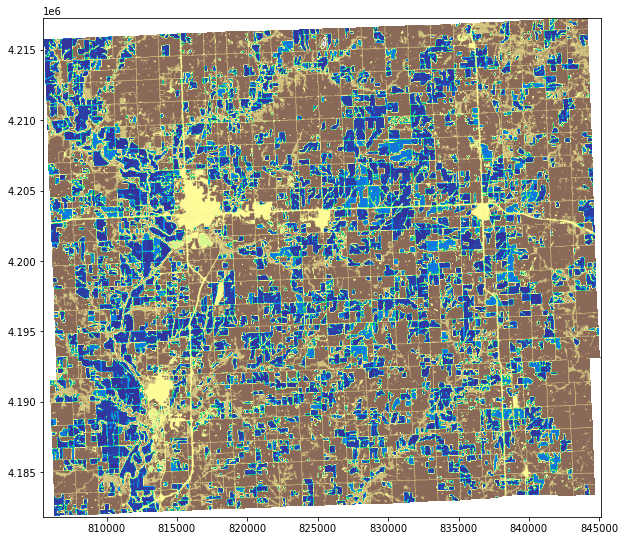

<AxesSubplot:>

In [34]:
# Tif crop image of crop area
plt.figure(figsize=(10,10))
rasterio.plot.show(cc_raster, cmap='terrain')

<AxesSubplot:>

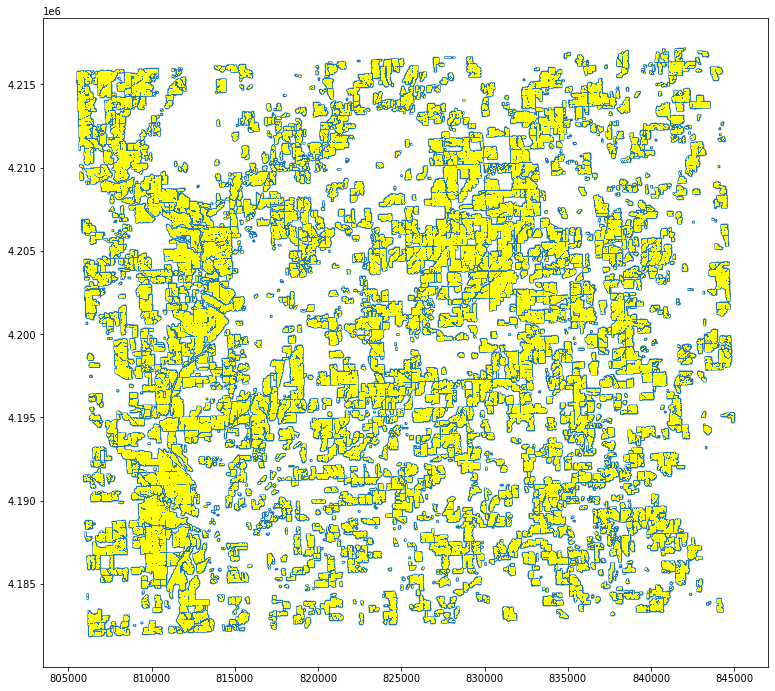

In [36]:
# Shape image of buffer and crop areas
f, ax = plt.subplots(figsize=(13,13))
selected_crop_vec_buffer.plot(ax=ax)
selected_crop_vec.plot(ax=ax, color='yellow')
